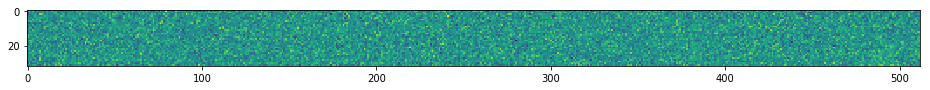

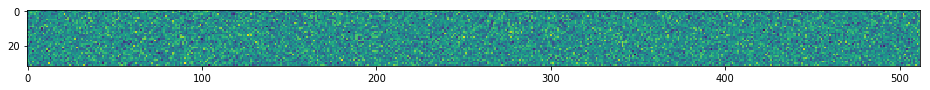

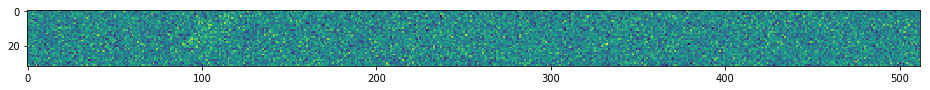

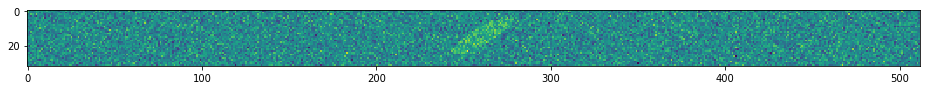

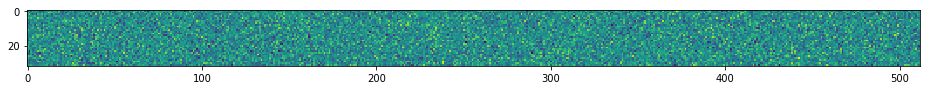

In [18]:
%matplotlib inline
#from blimpy import Waterfall
import pylab as plt
import numpy as np
from skimage.draw import (line, polygon, circle,
                          circle_perimeter,
                          ellipse, ellipse_perimeter,
                          bezier_curve)
from skimage import measure
import scipy.signal as scisig
from skimage.morphology import binary_dilation
from sklearn.cluster import DBSCAN, AgglomerativeClustering


# create training set of size 1000 * 32 * 512, inject 3 types of signals
n_img = 1000
shape0 = (32, 512)
p_ellip = 0.5; ellp_pop = np.random.uniform(size=n_img)<p_ellip  #labels
p_line = 0.1; line_pop = np.random.uniform(size=n_img)<p_line
p_circp = 0.01; circp_pop = np.random.uniform(size=n_img)<p_circp
img = np.random.normal(size=n_img*64*256).reshape(n_img, 32, 512)

for i in range(n_img):
    
    if line_pop[i]:
        start, length = np.random.randint(low=0, high=420), np.random.choice([32,36])
        #print('line', i, start, length)
        rr, cc = line(0, start, 31, start+length)
        img[i, rr, cc] += np.random.uniform(low=0.5, high=4)
    if ellp_pop[i]:
        x, y = np.random.randint(low=0, high=31), np.random.randint(low=0, high=511)
        rr, cc = ellipse(x, y, 5, 20, shape0, rotation=np.pi/6)
        #print('ellp', i, x, y)
        
        img[i, rr, cc] += np.random.uniform(low=0.5, high=2)
    if circp_pop[i]:
        x, y = np.random.randint(low=0, high=31), np.random.randint(low=0, high=511)
        rr, cc = circle_perimeter(x, y, radius=15, shape=shape0)
        #print(i)
        img[i, rr, cc] += np.random.uniform(low=0.5, high=4)

for i in range(5):
    plt.figure(figsize=(16,4))
    plt.imshow(img[i])
    plt.show()

In [19]:
# initialize kernels by convolution and thresholding
pix_thresh = 2
filter_shape = (32,64)
filt = np.ones(filter_shape, dtype=np.float32)
filt /=  filt.size

bina = (img>pix_thresh).astype(np.float32)

act = np.hstack([scisig.fftconvolve(b, filt, 'same') for b in bina])


In [20]:

# split resulting regions into kernels

def get_labels(T, dilation=None):
    #label thresholded into segmented regions
    #dilation: None or tuple for (nrows, ncols)
    if dilation is not None:
        T2 = binary_dilation(T.copy(), selem=np.ones(dilation))
        labels = measure.label(T2) * T
        return labels
    else:
        return measure.label(T)
    
pad = 64
T = act>np.amax(act)*0.34
lab = get_labels(T, dilation=(4,8))

kernels = []
img = np.hstack([im for im in img])
regions = measure.regionprops(label_image=lab, intensity_image=img)
for r in regions:
    row, col = np.asarray(r.weighted_centroid, dtype=np.int32)
    col = max(col, pad//2); col = min(col, img.shape[1]-pad//2)
    kernels.append(img[:,col-pad//2:col+pad//2])
    
kernels = np.asarray(kernels)
print(kernels.shape)

(470, 32, 64)


[[1.         0.95911197 0.95251493 ... 0.42848984 0.94253476 0.92563885]
 [0.95911197 1.         0.95456201 ... 0.40823211 0.87515679 0.9462076 ]
 [0.95251493 0.95456201 1.         ... 0.35684627 0.87911001 0.93940097]
 ...
 [0.42848984 0.40823211 0.35684627 ... 1.         0.73694409 0.57661037]
 [0.94253476 0.87515679 0.87911001 ... 0.73694409 1.         0.92821974]
 [0.92563885 0.9462076  0.93940097 ... 0.57661037 0.92821974 1.        ]]


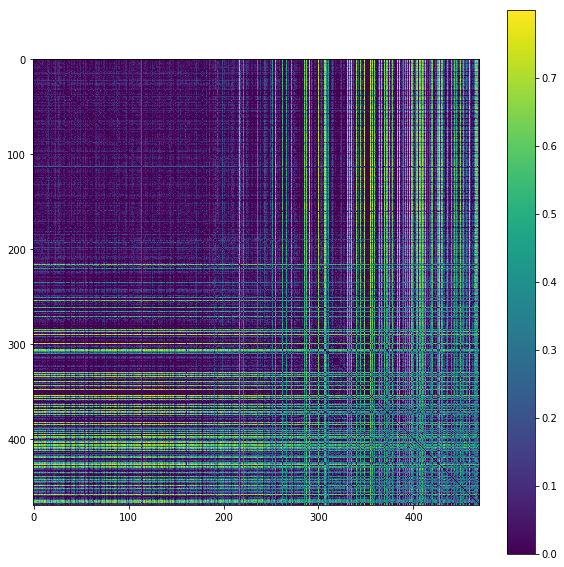

In [21]:
#compute affinity matrices based on the cross-correlation of the kernels with respect to each other

corr_mat = np.ones((kernels.shape[0],kernels.shape[0]))
cov_mat = np.ones((kernels.shape[0],kernels.shape[0]))
shift_mat = np.ones((kernels.shape[0],kernels.shape[0]))

#get diagonal
diags = []
for i,k in enumerate(kernels):
    a = scisig.fftconvolve(kernels[i], kernels[i], 'same')
    diags.append(np.amax(a))
    shift_mat[i,i] = 0
        
for i,k in enumerate(kernels):
    for j,m in enumerate(kernels):
        a = scisig.fftconvolve(kernels[i], kernels[j], 'same')
        cov_mat[i,j] = np.amax(a)
        a /= np.sqrt(diags[i]*diags[j])
        corr_mat[i,j] = np.amax(a)
        shift_mat[i,j] = np.argmax(a)
        #im = axes[i,j].imshow(a)
        #fig.colorbar(im, ax=axes[i,j])
print(corr_mat)        
cen_row, cen_col = np.unravel_index(np.asarray(shift_mat, dtype=np.int32), dims=kernels[0].shape)

affinity_mat = np.clip(1-corr_mat, 1.e-16, 1)
plt.figure(figsize=(10,10))
plt.imshow(affinity_mat)
plt.colorbar()
plt.show()

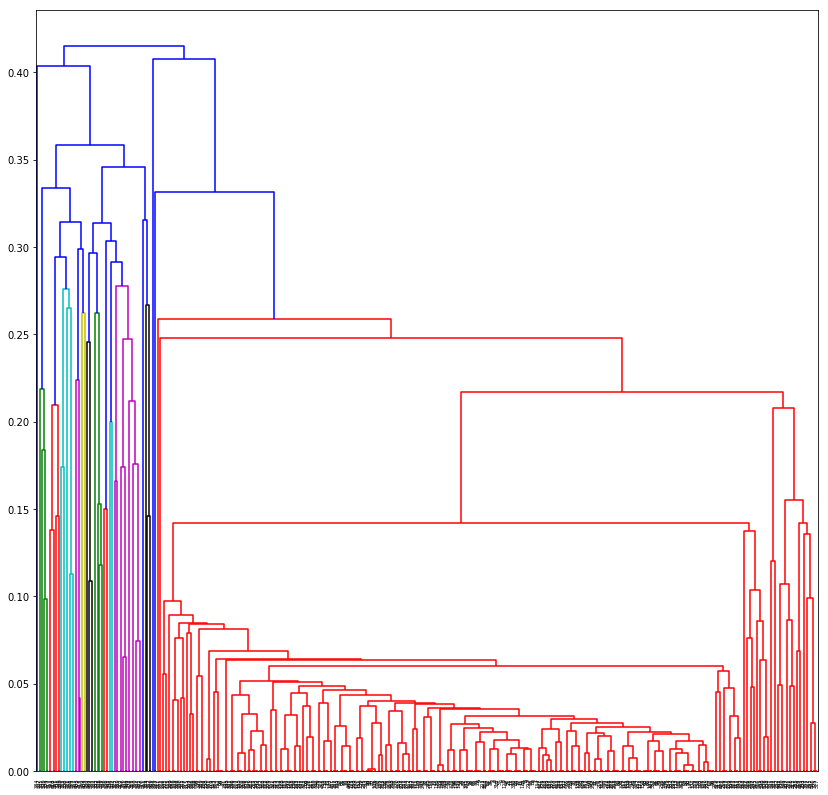

In [22]:
from scipy.cluster import hierarchy
affinity_condensed = affinity_mat[np.triu_indices(453)]
Z = hierarchy.linkage(affinity_condensed, 'average')
plt.figure(figsize=(14,14))
dn = hierarchy.dendrogram(Z)
plt.show()

In [23]:

def _get_shifted(k1, k0, shift):
    """
    function to return k1 shifted with respect to k0, padding with k0
    shift is the delta of k1 with respect to k0
    """
    
    SR,SC = k0.shape
    res = k0
    sr, sc = shift
    if sr >= 0 and sc >=0:
        res[sr:,sc:] = k1[:SR-sr, :SC-sc]
    elif sr >= 0 and sc < 0:
        res[sr:,:SC+sc] = k1[:SR-sr, -sc:]
    elif sr < 0 and sc < 0:
        res[:SR+sr,:SC+sc] = k1[-sr:, -sc:]
    elif sr < 0 and sc >=0:
        res[:SR+sr,sc:] = k1[-sr:, :SC-sc]
    return res
    
def combine_filters(kernels, evals, vecs, shifts):
    """
    Function to combine set of kernels by weighted averaging
    """
    sort_inds = np.argsort(evals)[::-1]
    vecs = vecs[sort_inds]
    evals = evals[sort_inds]
    new_kernels = np.zeros_like(kernels)
    for i, vec in enumerate(vecs):
        vec /= np.sqrt(np.sum(vec**2))
        main = np.argmax(np.abs(vec))
        if vec[main] < 0:
            vec = -vec
        shift = shifts[main]
        shift = (shift[main] - shift) #shift_shape is (col, srow, scol), it's the 
        kern_main = kernels[main].copy()
        for j, alpha in enumerate(vec):
            kernj = kernels[j].copy()
            
            if j != main:
                kernj = _get_shifted(kernj, kern_main.copy(), shift[j])
            new_kernels[i] += alpha * kernj
    return new_kernels
        

evals [4377.80485182  746.7394457  -599.46822114 -112.88988693  203.55793331]


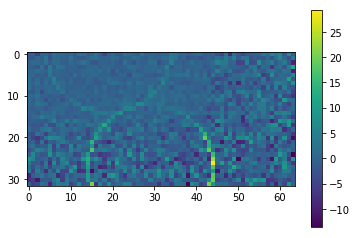

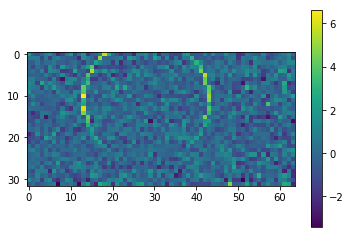

evals [211451.84772017 -11916.29367633   4136.89484645   2270.62388781
  -1110.08195878]


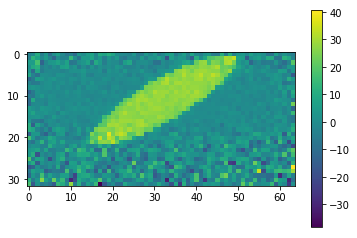

evals [8660.71111931  304.74032053 -240.47616205 -221.17236506  256.44539617]


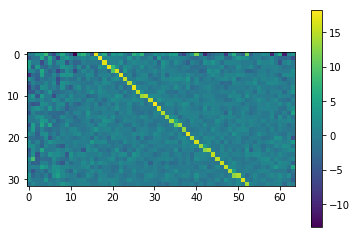

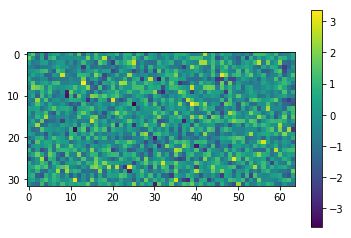

evals [6279.74822921  206.94990222 -200.29291902  173.79748993 -147.27485176]


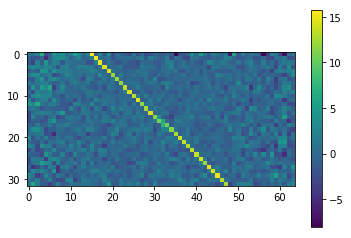

In [27]:
# First cluster with respect to affinity matrix. If clustering succeeds, reduces pca orthogonality constraint
#scanner = DBSCAN(eps=0.1, min_samples=2, metric="precomputed")
scanner = AgglomerativeClustering(n_clusters=5, linkage='average', affinity='precomputed')
clustering = scanner.fit(affinity_mat)
labels = np.unique(clustering.labels_)
clusters = []
for lab in labels:
    if lab < 0:
        continue
    clusters.append(np.where(clustering.labels_==lab)[0])
#print("cluster", clusters)


#Perform PCA on covariance matrices to keep the best components
new_kerns = []
for c in clusters:
    c = np.asarray(c)
    kerns = kernels[c]
    if c.size == 1:
        new_kerns.append(kerns[0])
        plt.figure()
        plt.imshow(kerns[0])
        plt.colorbar()
        plt.show()
        continue
    Y = cov_mat[np.ix_(c,c)]
    R = cen_row[np.ix_(c,c)]
    C = cen_col[np.ix_(c,c)]
    w, v = np.linalg.eig(Y)
    print('evals', w[:5])

    res = combine_filters(kerns, w, v.T, np.stack([R, C], axis=-1))
    j = 0
    while w[j] > w[0]*0.1:
        new_kerns.append(res[j])  #only append first result from each cluster
        plt.figure()
        plt.imshow(res[j])#*(res[j]>0))
        plt.colorbar()
        plt.show()
        j += 1

Clustering often doesn't work well, or requires good hyper-parameters, when the representation of the signals aren't balanced. This can be mitigated by first removing the highest contributing kernels to the highest PCA output. 

Things to try:
1. PCA and remove top element at a time. 
2. non negative matrix factorization (enforce translation)
3. ICA on PCA result (enforce translation)
4. hiearchical clustering

In [135]:
ktemp.shape

(2, 2048)

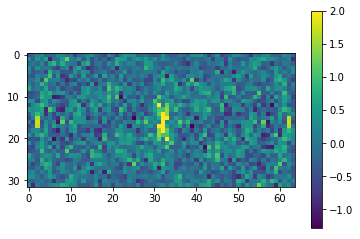

In [153]:
from numpy.fft import *
k = ifftshift(ifft2(np.abs(fft2(new_kerns[6].reshape((32,64))))).real)
plt.imshow(k, vmax=2)
plt.colorbar()
plt.show()

In [131]:
from sklearn.decomposition import FastICA
ktemp = new_kerns.copy()
ktemp = np.stack(ktemp)[:]
ksh = ktemp.shape
ktemp = ktemp.reshape((ksh[0], ksh[1]*ksh[2]))
transformer = FastICA(n_components=4)
k_trans = transformer.fit_transform(ktemp.T).T.reshape((4,32,64))

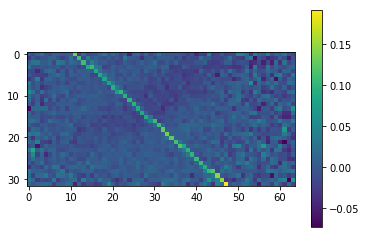

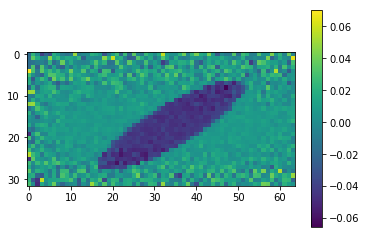

In [132]:
for k in k_trans:
    plt.figure()
    plt.imshow(k)
    plt.colorbar()
    plt.show()

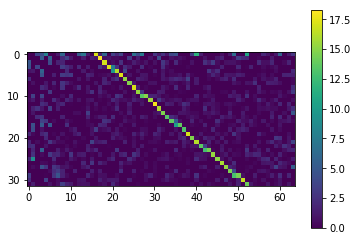

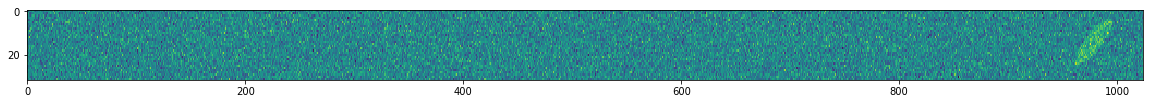

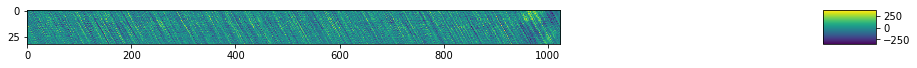

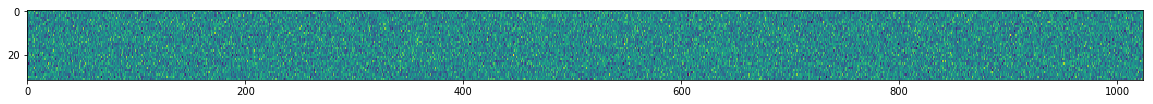

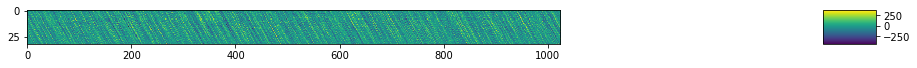

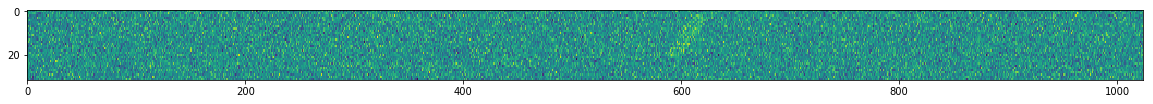

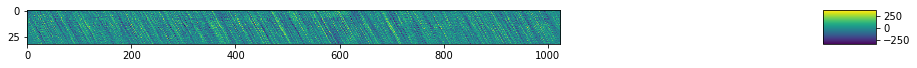

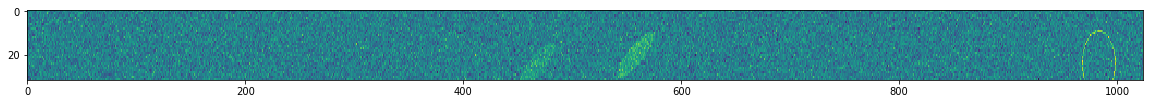

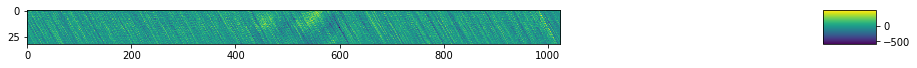

/home/yunfanz/miniconda3/envs/TF3/lib/python3.6/site-packages/matplotlib/image.py:863: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)


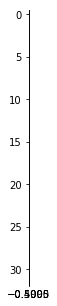

TypeError: Invalid dimensions for image data

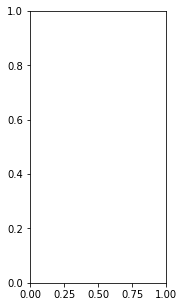

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
line_kern = np.zeros((32,64))
start, length = 15, 32
rr, cc = line(0, start, 31, start+length)
line_kern[rr, cc] += 4
kern = new_kerns[3]
kern = np.clip(kern, 0, np.amax(kern))
plt.figure()
plt.imshow(kern)
plt.colorbar()
plt.show()
for i in np.where(circp_pop)[0]:
    
    k = kern
    a = scisig.fftconvolve(img[:,i*1024:(i+1)*1024], k.astype(np.float32), 'same')
    b = scisig.fftconvolve(img[:,i*1024:(i+1)*1024], np.ones_like(k)*np.sum(k)/k.size, 'same')
    
    #a = scisig.convolve2d(img, np.random.normal(size=kernels[0].size).reshape(kernels[0].shape), 'full')
    plt.figure(figsize=(20, 5))
    plt.imshow(img[:,i*1024:(i+1)*1024], aspect=2)
    #plt.colorbar()
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.imshow(a-b, aspect=2)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.05)
    plt.colorbar(cax=cax)
    plt.show()

In [46]:
from kymatio import Scattering2D
import torch

In [60]:
sca = Scattering2D(J=2, shape=(32,64), L=8, max_order=1, pre_pad=False)

In [84]:
line_kern2 = np.random.normal(size=32*64).reshape((32,64))
start, length = 0, 48
rr, cc = line(0, start, 31, start+length)
line_kern2[rr, cc] += 4

a = sca(torch.Tensor(line_kern)).numpy()
an = sca(torch.Tensor(line_kern2)).numpy()

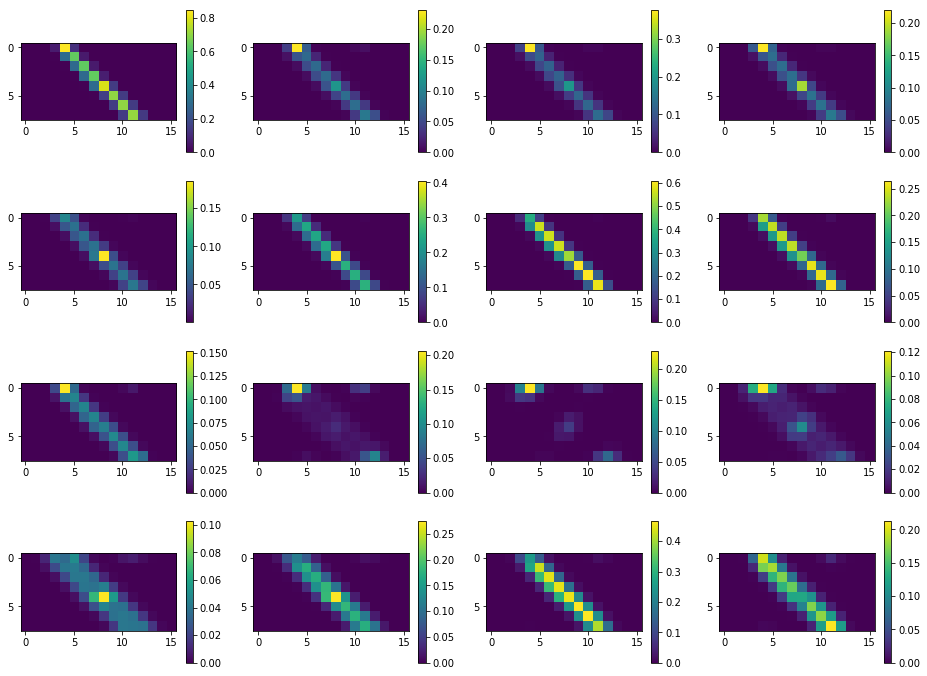

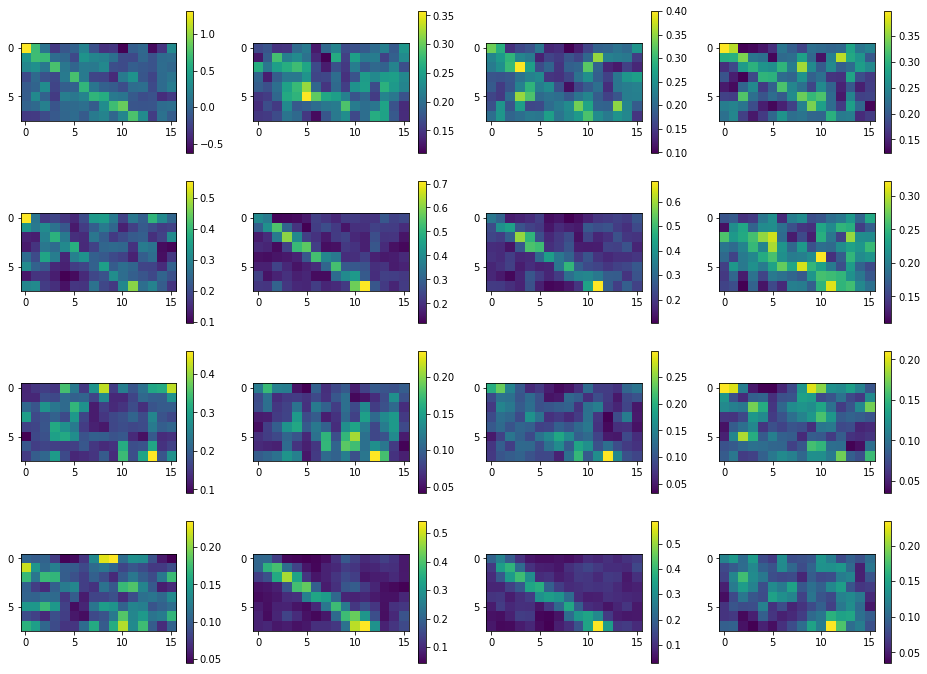

In [85]:
fig, axes = plt.subplots(4,4, figsize=(16,12))
for r in range(4):
    for c in range(4):
        im = axes[r,c].imshow(a[r*4+c])
        fig.colorbar(im, ax=axes[r,c])
plt.show()

fig, axes = plt.subplots(4,4, figsize=(16,12))
for r in range(4):
    for c in range(4):
        im = axes[r,c].imshow(an[r*4+c])
        fig.colorbar(im, ax=axes[r,c])
plt.show()

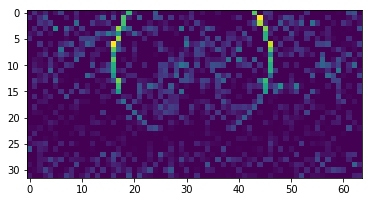

In [77]:
plt.imshow(k)